Date: 26th December 2023

In [ ]:
from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

In [1]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 39.2 MB/s eta 0:00:00


In [2]:
import numpy as np

**Aim**: We aim to replicate the results obtained by using our algorithm on the SIPAMPL database. We shall be selecting some of the problems from the database and then trying to solve them.

**Algorithm**: First we shall try to replicate the exact same Simulated Annealing algorithm as done in the DACC'22 paper.

**NULL Function 1** (Convert .mod file to PulP problem) <br>
Input: A text file in the form of a .mod file from the database which contains the problem definition <br>
Function: Convert it into a python code which uses PuLP <br>
Output: PuLP code   

**Function 2 (Store Constraints)** <br>
Function: Given the constraints which are a part of the problem given, store the coefficients in the form of an array. The dimension of the array which stores the coefficients is $(n,n+1)$ where $n$ is the dimension of the $X$ domain.


In [3]:
def evaluate_t_constraints(dimx, uncertainties):
    dimx_plus_1 = dimx + 1
    constraint_coeff_array = np.zeros((dimx, dimx_plus_1))

    for i in range(dimx):
        constraint_coeff_array[i][0] = -uncertainties[i][0]
        constraint_coeff_array[i][1] = -uncertainties[i][1]
        constraint_coeff_array[i][2] = -1
        constraint_coeff_array[i][3] = -1/6 * ((uncertainties[i][0] - 1)**2 +
                                                uncertainties[i][1]) \
                                        * (uncertainties[i][0] + (2 - uncertainties[i][1]))

    return constraint_coeff_array

In [4]:
# Example usage:
n = 3  # replace with the actual value of dimx
uncertainties_array = np.array([[1, 0], [2, 0], [3, 0]])  # replace with the actual uncertainties array

result_coefficients = evaluate_t_constraints(n, uncertainties_array)
print("Resulting Coefficients Array:")
print(result_coefficients)

Resulting Coefficients Array:
[[-1.          0.         -1.         -0.        ]
 [-2.          0.         -1.         -0.66666667]
 [-3.          0.         -1.         -3.33333333]]


**Function 3 (Convert to PuLP problem)** <br>
Function: Convert the given problem to a PuLP problem. The input passed is the coefficient array which was defined before. The PuLP problem is given as a module which computes the optimal value of the input problem on the basis of the coefficients.

In [5]:
from pulp import LpProblem, LpMinimize, LpVariable, LpStatus, PULP_CBC_CMD

def solve_for_G_of_omega(constraint_coeff_array, dimx, MINIMUM_N=-1e8, MAXIMUM_N=1e8):
    prob = LpProblem("FindG", LpMinimize)
    set_x = range(dimx)

    G_omega = LpVariable.dicts("x", lowBound=MINIMUM_N, upBound=MAXIMUM_N, indices=set_x, cat='Continuous')
    prob += G_omega[2]

    for i in set_x:
        prob += 0 >= G_omega[0] * constraint_coeff_array[i][0] + \
                      G_omega[1] * constraint_coeff_array[i][1] + \
                      G_omega[2] * constraint_coeff_array[i][2] + \
                      constraint_coeff_array[i][3]

    prob.solve(PULP_CBC_CMD())

    # Print solver status
    #print("Solver status:", LpStatus[prob.status])

    G_of_omega = np.array([G_omega[i].varValue for i in set_x])

    return G_of_omega[2]

In [6]:
# Example usage:
dimx = 3  # replace with the actual value of dimx
MINIMUM_N = -1e8  # replace with the actual minimum value
MAXIMUM_N = 1e8 # replace with the actual maximum value

# Assuming you have the constraint_coeff_array
constraint_coeff_array =evaluate_t_constraints(3, np.array([[0, 10e-5       ],\
 [0.88774755  ,0.6832124 ],\
 [1.39025533 ,2.        ]]))
result = solve_for_G_of_omega(constraint_coeff_array, dimx, MINIMUM_N, MAXIMUM_N)
print("Result:", result)

Result: -10000.333


**Function 4 (Skeleton of Simulated Annealing)** <br>
Function: To run simulated annealing to converge to the optimal value. We want to algorithm to work in the following way. We first have a sampling set $U^n$ from which we want to sample points. The set $U$ itself is a subset of $R^k$ where $R$ is the real number line. The optimization procedure takes place over the space $U^n$. Now, the optimization function which we want to maximise is the following, for each $\omega \in U^n$, we compute a function value $G(\omega)$ which can be obtained by solving the optimization problem which we defined using the PuLP module. <br>

The Simulated Annealling algorithm must have a pseudocode of the following form: <br>
1) Sample a point $\omega$ from the set $U^n$. <br>
2) Compute the value of $G(\omega)$ for that point <br>
3) Use some kind of acceptance-rejectance sampling (default = Metropolis algorithm) <br>
3.1) The cooling schedule used in the Simulated Annealing algorithm must be of the form $\frac{C}{log(T + 1)}$ where $T$ denotes the iteration number and $C$ is a carefully chosen constant <br>
4) Continue this optimization for a fixed number of iterations <br>

**Function 5 (Gaussian Markov Kernel)** <br>
Function: We have an element $\omega \in U^n$. From that we want to go to a new element $\omega' \in U^n$. The selection for the new point can be done using a Gaussian kernel centred at the current point and truncated over the interval $I$. This means that for now we shall favour the elements closer to our current point. <br>
Code: We thus want to write a python function which takes in a current point $\omega$, applies the required transformation on it and returns the new point.   

In [7]:
import numpy as np

def gaussian_markov_kernel(omega, sigma, interval_I):
    """
    Apply Gaussian Markov Kernel to generate a new point.

    Parameters:
    - omega: Current point in U^n.
    - sigma: Standard deviation of the Gaussian kernel.
    - interval_I: Interval for truncation.

    Returns:
    - omega_prime: New point generated using the Gaussian Markov Kernel.
    """

    # Generate random values from a normal distribution with mean 0 and standard deviation sigma
    gaussian_noise = np.random.normal(0, sigma, size=omega.shape)

    # Add the noise to the current point
    omega_prime = omega + gaussian_noise

    # Truncate the values to the interval I
    omega_prime = np.clip(omega_prime, interval_I[0], interval_I[1])

    return omega_prime



In [8]:
# Example usage:
current_point = np.array([[1, 0], [2, 0], [0, 0.5]])  # Replace with your actual current point
standard_deviation = 0.1  # Adjust the standard deviation as needed
truncation_interval = (0, 2)  # Adjust the interval I as needed

new_point = gaussian_markov_kernel(current_point, standard_deviation, truncation_interval)
print("Current Point:\n", current_point)
print("New Point:\n", new_point)


Current Point:
 [[1.  0. ]
 [2.  0. ]
 [0.  0.5]]
New Point:
 [[0.99741766 0.24564904]
 [1.98118503 0.06116257]
 [0.03445883 0.82405249]]


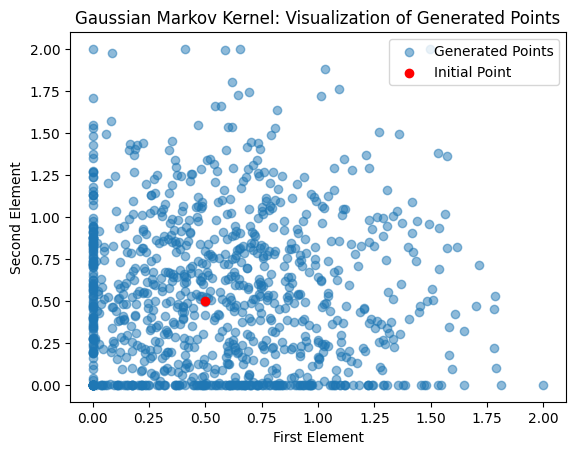

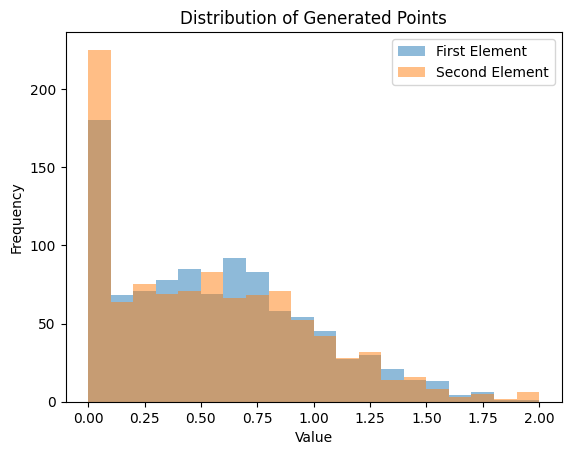

In [ ]:
# Set the seed for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# Initial point
initial_point = np.array([0.5, 0.5, 0.5])  # Replace with your actual initial point

# Parameters
standard_deviation = 0.5
closed_interval_I = (0, 2)

# Number of iterations
num_iterations = 1000

# Store new points for visualization
new_points = []

# Run the function 100 times independently
for _ in range(num_iterations):
    new_point = gaussian_markov_kernel(initial_point, standard_deviation, closed_interval_I)
    new_points.append(new_point)

# Extract the first two elements for visualization
new_points_array = np.array(new_points)
x_values = new_points_array[:, 0]
y_values = new_points_array[:, 1]

# Plot the first two elements of the new points
plt.scatter(x_values, y_values, alpha=0.5, label='Generated Points')
plt.scatter(initial_point[0], initial_point[1], color='red', label='Initial Point')
plt.title('Gaussian Markov Kernel: Visualization of Generated Points')
plt.xlabel('First Element')
plt.ylabel('Second Element')
plt.legend()
plt.show()

# Plot the distribution to ensure it resembles a Gaussian
plt.hist(x_values, bins=20, alpha=0.5, label='First Element')
plt.hist(y_values, bins=20, alpha=0.5, label='Second Element')
plt.title('Distribution of Generated Points')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Function 5.5 (Beta Markov Kernel)** <br>
Function: Implement a beta markov kernel in the interval $(a,b)$ with mean $\mu$

In [ ]:
import numpy as np

def beta_markov_kernel(omega, interval_I, sigma):
    """
    Apply Beta Markov Kernel to generate a new point.

    Parameters:
    - omega: Current point in U^n.
    - interval_I: Interval for truncation.
    - sigma: Standard deviation of the Beta distribution.

    Returns:
    - omega_prime: New point generated using the Beta Markov Kernel.
    """

    # Rescale distribution to the range of (0, 1)
    scale_factor = interval_I[1] - interval_I[0]
    std_mu = (omega - interval_I[0]) / scale_factor
    std_sigma = sigma / scale_factor

    # Convert mu/sigma to alpha/beta as used by numpy.random.beta()
    nu = std_mu * (1.0 - std_mu) / (std_sigma * std_sigma) - 1.0
    alpha_param = 1.0 + np.abs(nu)
    beta_param = 1.0 + np.abs(-nu)

    # Generate std betas, scale, and translate back to the original parameterization
    beta_sample = scale_factor * np.random.beta(alpha_param, beta_param)

    # Clip the values to the specified interval
    omega_prime = np.clip(beta_sample, interval_I[0], interval_I[1])

    return omega_prime



In [ ]:
# Example usage:
current_point = np.array([[1, 0], [2, 0], [0, 0.5]])  # Replace with your actual current point
standard_deviation = 0.1  # Adjust the standard deviation as needed
truncation_interval = (0, 2)  # Adjust the interval I as needed

new_point = beta_markov_kernel(current_point,  truncation_interval, standard_deviation)
print("Current Point:\n", current_point)
print("New Point:\n", new_point)

Current Point:
 [[1.  0. ]
 [2.  0. ]
 [0.  0.5]]
New Point:
 [[0.90431308 0.31621161]
 [0.39579991 1.08028973]
 [0.83755635 1.05268567]]


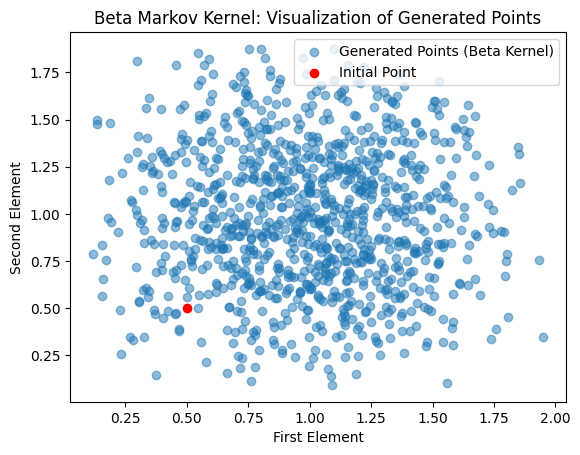

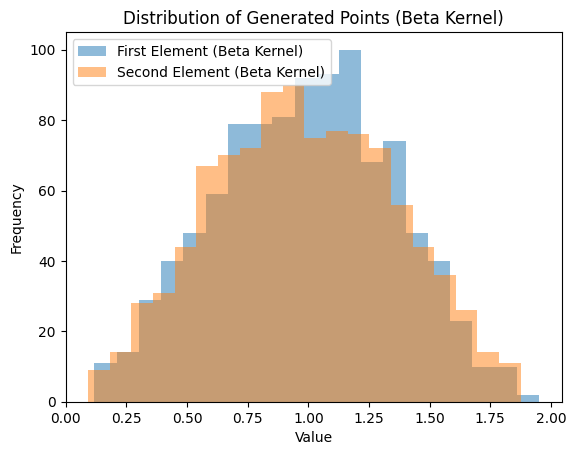

In [ ]:
# Set the seed for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

# Initial point
initial_point = np.array([0.5, 0.5, 0.5])  # Replace with your actual initial point

# Parameters
standard_deviation = 0.5
closed_interval_I = (0, 2)

# Number of iterations
num_iterations = 1000

# Store new points for visualization
new_points_beta = []

# Run the function 100 times independently
for _ in range(num_iterations):
    new_point_beta = beta_markov_kernel(initial_point, closed_interval_I, standard_deviation)
    new_points_beta.append(new_point_beta)

# Extract the first two elements for visualization
new_points_array_beta = np.array(new_points_beta)
x_values_beta = new_points_array_beta[:, 0]
y_values_beta = new_points_array_beta[:, 1]

# Plot the first two elements of the new points using Beta Markov Kernel
plt.scatter(x_values_beta, y_values_beta, alpha=0.5, label='Generated Points (Beta Kernel)')
plt.scatter(initial_point[0], initial_point[1], color='red', label='Initial Point')
plt.title('Beta Markov Kernel: Visualization of Generated Points')
plt.xlabel('First Element')
plt.ylabel('Second Element')
plt.legend()
plt.show()

# Plot the distribution to ensure it resembles a Beta distribution
plt.hist(x_values_beta, bins=20, alpha=0.5, label='First Element (Beta Kernel)')
plt.hist(y_values_beta, bins=20, alpha=0.5, label='Second Element (Beta Kernel)')
plt.title('Distribution of Generated Points (Beta Kernel)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()



**Function 5.5.2 (Four-Parameter Beta Distribution)** <br>
Function: Upper bound $u$, Lower Bound $l$, mean given by $\mu = \frac{α}{α + β}\times (u - l) + l$. Hence, $\beta = \alpha \frac{u - \mu}{\mu - l} > 0$. Further, the mean shall be obtained by the following scaling: <br>
Map the interval $(l,u)$ to the interval $(l + 0.1*(u-l), u - 0.1*(u-l))$ and then obtain $\mu$ from $\omega$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def fp_beta_markov_kernel(omega, interval_I, alpha):
    """
    Apply Beta Markov Kernel to generate a new point.

    Parameters:
    - omega: Current point in U^n.
    - interval_I: Interval for truncation (tuple of the form (lower_bound, upper_bound)).
    - alpha: Shape parameter.

    Returns:
    - omega_prime: New point generated using the Beta Markov Kernel.
    """

    # Set lower bound (l) and upper bound (u) from the interval
    l, u = interval_I

    gap = 0.0001
    scaled_l = l + gap * (u - l)
    scaled_u = u - gap * (u - l)

    # Obtain mu from omega
    mu = (omega - l)*(1 - 2*gap) + scaled_l
    # Compute beta based on the current point omega
    beta_value = np.maximum((alpha * ((u - mu))) / ((mu - l)),1e-9)

    # Generate a new point omega_prime using the Beta distribution
    omega_prime = beta.rvs(alpha, beta_value, loc=l, scale=(u - l))

    # Clip the values to the specified interval
    omega_prime = np.clip(omega_prime, l, u)

    return omega_prime





In [ ]:
# Example usage:
initial_point = np.array([0.5, 0.5, 0.5])
interval_I = (0, 2)
alpha = 2.0

# Apply Beta Markov Kernel to generate a new point
new_point = fp_beta_markov_kernel(initial_point, interval_I, alpha)
print("Current Point:\n", initial_point)
print("New Point:\n", new_point)

Current Point:
 [0.5 0.5 0.5]
New Point:
 [0.78057877 1.02409496 0.48654678]


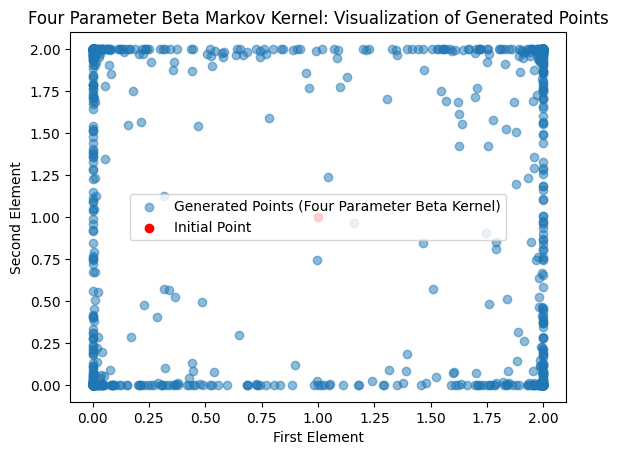

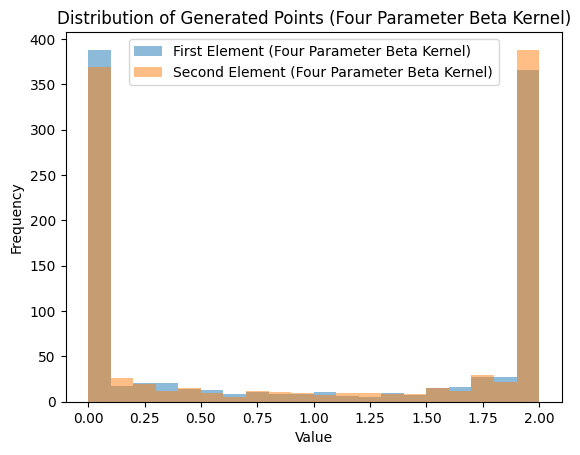

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)

# Initial point
initial_point = np.array([1, 1])  # Replace with your actual initial point

# Parameters for Beta Markov Kernel
closed_interval_I = (0, 2)
alpha = 0.1
# Number of iterations
num_iterations = 1000

# Store new points for visualization
new_points_beta = []

# Run the function num_iterations times independently
for _ in range(num_iterations):
    new_point_beta = fp_beta_markov_kernel(initial_point, closed_interval_I, alpha)
    new_points_beta.append(new_point_beta)

# Extract the first two elements for visualization
new_points_array_beta = np.array(new_points_beta)
x_values_beta = new_points_array_beta[:, 0]
y_values_beta = new_points_array_beta[:, 1]

# Plot the first two elements of the new points using Beta Markov Kernel
plt.scatter(x_values_beta, y_values_beta, alpha=0.5, label='Generated Points (Four Parameter Beta Kernel)')
plt.scatter(initial_point[0], initial_point[1], color='red', label='Initial Point')
plt.title('Four Parameter Beta Markov Kernel: Visualization of Generated Points')
plt.xlabel('First Element')
plt.ylabel('Second Element')
plt.legend()
plt.show()

# Plot the distribution to ensure it resembles a Beta distribution
plt.hist(x_values_beta, bins=20, alpha=0.5, label='First Element (Four Parameter Beta Kernel)')
plt.hist(y_values_beta, bins=20, alpha=0.5, label='Second Element (Four Parameter Beta Kernel)')
plt.title('Distribution of Generated Points (Four Parameter Beta Kernel)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Function 5.6 (Truncated Normal Markov Kernel)** <br>
Function: Use the truncated normal markov kernel, centred at the current point $\omega$ to produce the new point $\omega'$

In [9]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

def truncated_normal_markov_kernel(omega, sigma, interval_I):
    """
    Apply Truncated Normal Markov Kernel to generate a new point.

    Parameters:
    - omega: Current point in U^n.
    - sigma: Standard deviation of the Truncated Normal kernel.
    - interval_I: Interval for truncation.

    Returns:
    - omega_prime: New point generated using the Truncated Normal Markov Kernel.
    """

    # Define the truncation range
    a, b = interval_I[0], interval_I[1]

    # Generate random values from a truncated normal distribution
    lower_bound = (a - omega) / sigma
    upper_bound = (b - omega) / sigma
    omega_prime_scaled = truncnorm.rvs(lower_bound, upper_bound, loc=omega, scale=sigma)

    return omega_prime_scaled




In [10]:
# Example usage:
omega = 0.5
sigma = 0.1
interval_I = (0, 1)

# Generate a new point using the Truncated Normal Markov Kernel
omega_prime = truncated_normal_markov_kernel(omega, sigma, interval_I)

print("Current Point:", omega)
print("New Point (Truncated Normal):", omega_prime)

Current Point: 0.5
New Point (Truncated Normal): 0.3536953492074151


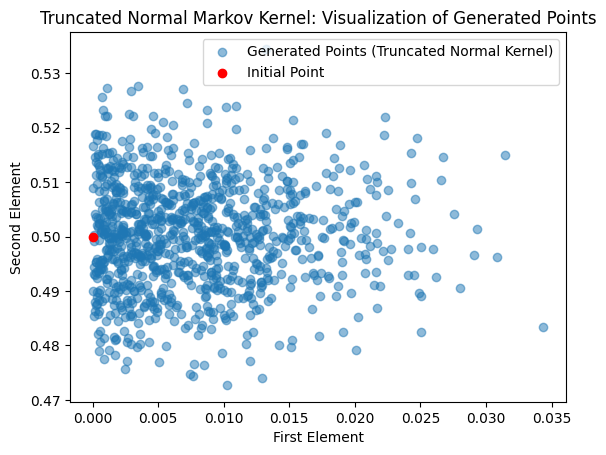

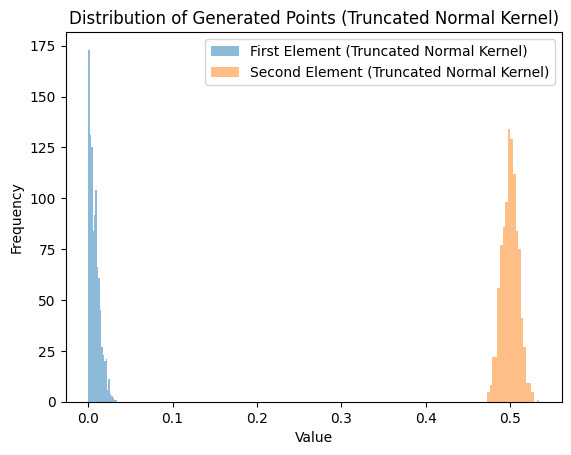

In [11]:
# Set the seed for reproducibility
np.random.seed(42)

# Initial point
initial_point = np.array([0, 0.5])  # Replace with your actual initial point

# Parameters for Truncated Normal Markov Kernel
closed_interval_I = (0, 2)
sigma = 0.01  # Standard deviation for Truncated Normal Markov Kernel
# Number of iterations
num_iterations = 1000

# Store new points for visualization
new_points_truncated_normal = []

# Run the function num_iterations times independently
for _ in range(num_iterations):
    new_point_truncated_normal = truncated_normal_markov_kernel(initial_point, sigma, closed_interval_I)
    new_points_truncated_normal.append(new_point_truncated_normal)

# Extract the first two elements for visualization
new_points_array_truncated_normal = np.array(new_points_truncated_normal)
x_values_truncated_normal = new_points_array_truncated_normal[:, 0]
y_values_truncated_normal = new_points_array_truncated_normal[:, 1]

# Plot the first two elements of the new points using Truncated Normal Markov Kernel
plt.scatter(x_values_truncated_normal, y_values_truncated_normal, alpha=0.5, label='Generated Points (Truncated Normal Kernel)')
plt.scatter(initial_point[0], initial_point[1], color='red', label='Initial Point')
plt.title('Truncated Normal Markov Kernel: Visualization of Generated Points')
plt.xlabel('First Element')
plt.ylabel('Second Element')
plt.legend()
plt.show()

# Plot the distribution to ensure it resembles a Truncated Normal distribution
plt.hist(x_values_truncated_normal, bins=20, alpha=0.5, label='First Element (Truncated Normal Kernel)')
plt.hist(y_values_truncated_normal, bins=20, alpha=0.5, label='Second Element (Truncated Normal Kernel)')
plt.title('Distribution of Generated Points (Truncated Normal Kernel)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


**Function 6 (Cooling Schedule)** <br>
Function: We wish to implement a cooling schedule that goes as $\frac{C}{log(T+1)}$. We want to write a python function which takes in the current time $T$ as an input and then returns back the cooling rate (the multiplier) at that instant back <br>

In [12]:
import numpy as np

def cooling_schedule(T, C=1.0):
    """
    Cooling schedule function.

    Parameters:
    - T: Current time.
    - C: Scaling factor.

    Returns:
    - cooling_rate: Cooling rate at the given time.
    """

    cooling_rate = C / np.log(T + 1)

    return cooling_rate


In [13]:
# Example usage:
current_time = 5  # Replace with your actual current time
cooling_rate_value = cooling_schedule(current_time)

print(f"At time {current_time}, the cooling rate is: {cooling_rate_value}")

At time 5, the cooling rate is: 0.5581106265512472


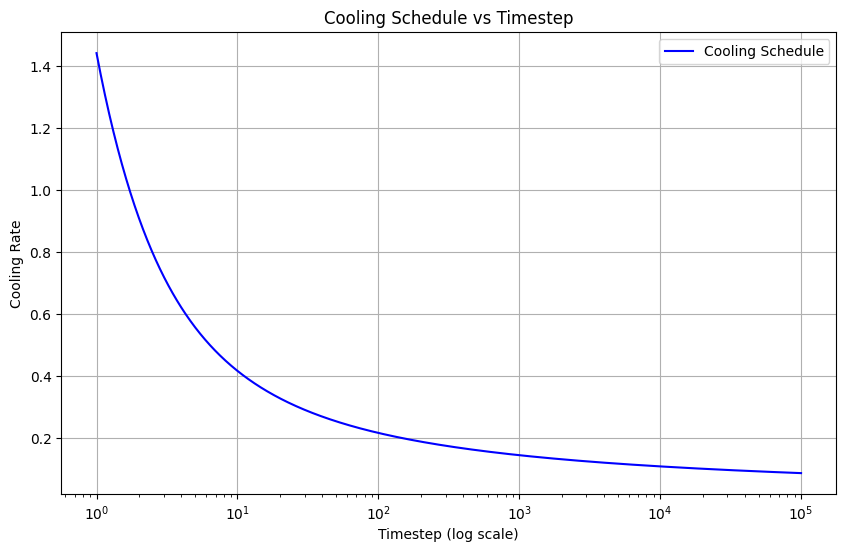

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Generate timestep values in log scale from 1 to 10^5
timesteps = np.logspace(0, 5, num=1000)

# Calculate cooling rates for each timestep
cooling_rates = [cooling_schedule(T) for T in timesteps]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(timesteps, cooling_rates, label='Cooling Schedule', color='blue')
plt.xscale('log')
plt.title('Cooling Schedule vs Timestep')
plt.xlabel('Timestep (log scale)')
plt.ylabel('Cooling Rate')
plt.legend()
plt.grid(True)
plt.show()


**Function 7 (Accept or Reject?)** <br>
Function: We want to perform accept reject sampling. This is done in the following way. We have a current point $\omega$ and a new point $\omega'$ is generated using the gaussian markov function which we have defined before (we can directly call this function). We also have a defined function which computes a function $y = G(\omega), y' = G(\omega')$ for both of these points. We also have $y_0$ which is the maximum value ever. Next we generate a random number $\eta$ uniformly from the interval $(0,1)$. We also generate $T_N$ using the cooling schedule function that we had defined before. If $y' > y_0$ then we select $y'$ (Acceptance). Otherwise, we accept if the quantity $\exp(\frac{y' - y_0}{T_N}) \geq \eta$ and then replace $\omega$ by $\omega'$. <br>

**Function 7.5 (Initial Point)** <br>
Given an interval $I$ and $n,k$ which are dimensions of an array, generate a numpy array of dimension $n \times k$ and initialize it elementwise with a number randomly chosen from the interval $I$.

In [15]:
import numpy as np

def generate_initial_point(n, k, interval_I):
    """
    Generate an initial point numpy array of dimension n x k with random values from interval I.

    Parameters:
    - n: Number of rows.
    - k: Number of columns.
    - interval_I: Tuple representing the interval (start, end).

    Returns:
    - initial_point: Numpy array of shape (n, k) with random values from interval I.
    """
    start, end = interval_I
    end_inclusive = end + 1e-10  # A small offset to include the endpoint
    initial_point = np.random.uniform(start, end_inclusive, size=(n, k))
    return initial_point







In [16]:
# Example usage:
interval_I = (0, 2)  # Adjust the interval I as needed
n = 3  # Number of rows
k = 2  # Number of columns

initial_point = generate_initial_point(n, k, interval_I)
print("Initial Point:\n", initial_point)

Initial Point:
 [[0.52341137 0.4939576 ]
 [1.81250916 0.4990924 ]
 [0.54389945 1.51879652]]


**Function 8 (Simulated Annealing Initialization)** <br>
Function: Perform the initialization step in simulated annealing

In [17]:
import numpy as np

def simulated_annealing_init(tau, C, dimx, dimu, interval_I):
    """
    Initialization for Simulated Annealing.

    Parameters:
    - tau: Number of iterations.
    - C: Temperature parameter (C > 0).
    - dimx: Dimension of X set.
    - dimu: Dimension of U set.
    - interval_I: Tuple representing the interval (start, end).

    Returns:
    - initial_points: Numpy array of shape (tau, dimu) representing initial constraint point.
    - y_0: Initial value of G.
    - y_max: Maximum value of G.
    """
    initial_point = generate_initial_point(dimx, dimu, interval_I)

    # Evaluate y_0 for each initial point
    y_0 = solve_for_G_of_omega(evaluate_t_constraints(dimx, initial_point), dimx, MINIMUM_N=-1e8, MAXIMUM_N=1e8)

    y_max = y_0

    return initial_point, y_0, y_max

In [18]:
# Example usage:
tau = 100  # Number of iterations
C = 0.1  # Temperature parameter (C > 0)
dimx = 3  # Dimension of X set
dimu = 2  # Dimension of U set
interval_I = (0, 2)  # Interval for constraint points

initial_points, y_0, y_max = simulated_annealing_init(tau, C, dimx, dimu, interval_I)

print("Initial Constraint Points:\n", initial_points)
print("y_0:", y_0)
print("y_max:", y_max)

Initial Constraint Points:
 [[0.89947968 1.55342111]
 [0.13073232 0.97514239]
 [0.0672272  0.12530641]]
y_0: -19253361.0
y_max: -19253361.0


**Function 9 (Simulated Annealing)** <br>
Function: Perform the complete simulated annealling loop.

In [19]:
import numpy as np

def simulated_annealing(tau, C, dimx, dimu, interval_I, sigma=1.0):
    """
    Simulated Annealing algorithm.

    Parameters:
    - tau: Number of iterations.
    - C: Temperature parameter (C > 0).
    - dimx: Dimension of X set.
    - dimu: Dimension of U set.
    - interval_I: Tuple representing the interval (start, end).
    - sigma: Standard deviation for Gaussian Markov kernel.

    Returns:
    - optimal_points: List of best points found during the iterations.
    - optimal_values: List of corresponding maximum values of G.
    """
    # Initialization
    initial_point, y_0, y_max = simulated_annealing_init(1, C, dimx, dimu, interval_I)
    optimal_points = [initial_point]
    u_points = [initial_point]
    optimal_values = [y_max]
    u_max = initial_point
    exchanges = []

    N = 1  # Iteration counter

    while N < tau:
        # Sample new point u_n
        u_n = truncated_normal_markov_kernel(u_points[-1],sigma, interval_I)

        # Compute y_n for the new point
        y_n = solve_for_G_of_omega(evaluate_t_constraints(dimx, u_n), dimx, MINIMUM_N=-1e8, MAXIMUM_N=1e8)

        # Sample eta from unif(0, 1)
        eta = np.random.uniform()

        # Compute cooling schedule to obtain T_N
        T_N = cooling_schedule(N, C)


        # Update optimal value if y_n > y_0
        if y_n > y_0:
            y_0 = y_n
            u_points.append(u_n)
            exchanges.append(1)

        # Acceptance criteria
        elif np.exp((y_n - y_0) / T_N) > eta:
            # Do not change u_n
            u_points.append(u_points[-1])
            exchanges.append(0)
            pass
        else:
          u_points.append(u_n)
          exchanges.append(1)
        #print("Iter: ",N,"y_n: ",y_n,"y_0: ",y_0, "T_N: ", T_N, "Eta: ", eta, "Delta_E: " ,  np.exp((y_n - y_0) / T_N))

        # Update y_max and u_max if needed
        if y_0 >= y_max:
            y_max = y_0
        if y_n >= y_max:
            optimal_points.append(u_points[-1])


        # Update iteration counter
        optimal_values.append(y_max)
        N += 1
    u_max = optimal_points[-1]
    return optimal_points, optimal_values, u_max, u_points, exchanges


In [24]:
import time
# Example usage:
tau = 10000# Number of iterations
C = 10e10 # Temperature parameter (C > 0)
dimx = 3  # Dimension of X set
dimu = 2  # Dimension of U set
interval_I = (0, 2)  # Interval for constraint points
sigma = 0.5  # Standard deviation for Gaussian Markov kernel
alpha = 1 # Alpha value for the Four Parameter Beta Markov kernel

start_time = time.time()
optimal_points, optimal_values, u_max, u_points, exchanges = simulated_annealing(tau, C, dimx, dimu, interval_I, sigma)
end_time = time.time()
for i, (point, value) in enumerate(zip(u_points, optimal_values), 1):
  if i % 100 == 1:
    print(f"Iteration {i}: U Point = {point}, Optimal Value = {value}")

# for i, exchange in enumerate(zip(exchanges), 1):
#     print(f"Iteration {i}: Exchanges = {exchange}")

print("U_max: ",u_max)
#print("Optimal_points: ", optimal_points)
print("Time_Elapsed: ", end_time - start_time )

Iteration 1: U Point = [[1.37384382 0.60640294]
 [0.87095218 1.79125426]
 [1.89981522 1.43763469]], Optimal Value = -100000000.0
Iteration 101: U Point = [[0.12131834 0.00164303]
 [0.59377712 1.47106539]
 [1.62524977 1.48936528]], Optimal Value = -12296138.0
Iteration 201: U Point = [[0.01311314 0.03362787]
 [0.02684017 1.42197499]
 [1.49683285 0.99489453]], Optimal Value = -4674100.8
Iteration 301: U Point = [[0.01311314 0.03362787]
 [0.02684017 1.42197499]
 [1.49683285 0.99489453]], Optimal Value = -4674100.8
Iteration 401: U Point = [[0.01311314 0.03362787]
 [0.02684017 1.42197499]
 [1.49683285 0.99489453]], Optimal Value = -4674100.8
Iteration 501: U Point = [[0.01311314 0.03362787]
 [0.02684017 1.42197499]
 [1.49683285 0.99489453]], Optimal Value = -4674100.8
Iteration 601: U Point = [[0.01311314 0.03362787]
 [0.02684017 1.42197499]
 [1.49683285 0.99489453]], Optimal Value = -4674100.8
Iteration 701: U Point = [[0.01311314 0.03362787]
 [0.02684017 1.42197499]
 [1.49683285 0.994894

**Function 10 (Optimal Value Graph)** <br>
Function: Plot the optimal value achieved by the algorithm against the number of iterations

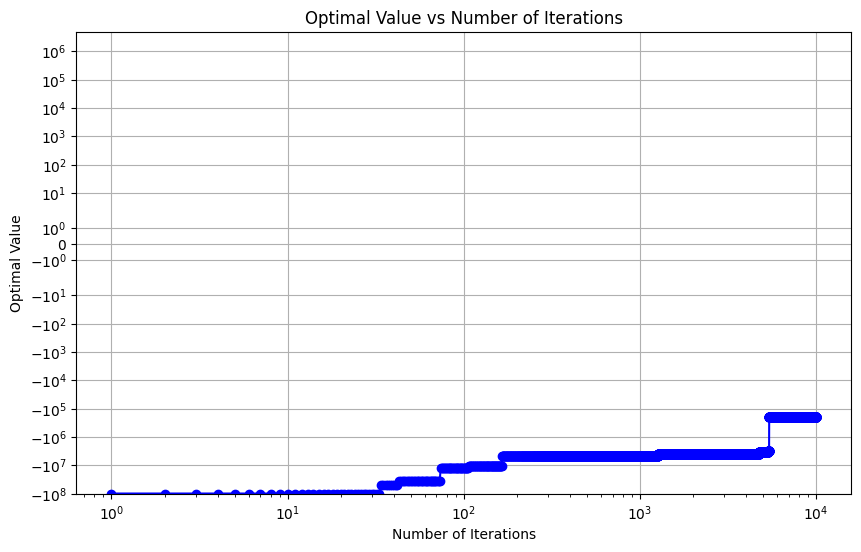

In [30]:
import matplotlib.pyplot as plt

def plot_optimal_values(optimal_values, log_scale=False):
    """
    Plot the graph of optimal values against the number of iterations.

    Parameters:
    - optimal_values: List of optimal values.
    - log_scale: Boolean, whether to use a logarithmic scale for the x-axis.
    """
    iterations = range(1, len(optimal_values) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, optimal_values, marker='o', linestyle='-', color='b')
    plt.title('Optimal Value vs Number of Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Optimal Value')

    if log_scale:
        plt.xscale('log')
        plt.yscale('symlog')

    plt.grid(True)
    plt.show()

# Example usage:
plot_optimal_values(optimal_values, log_scale=True)


**Function 10 (Plot exchanges)** <br>
Function: Plot the exchange whenever it happens <br>

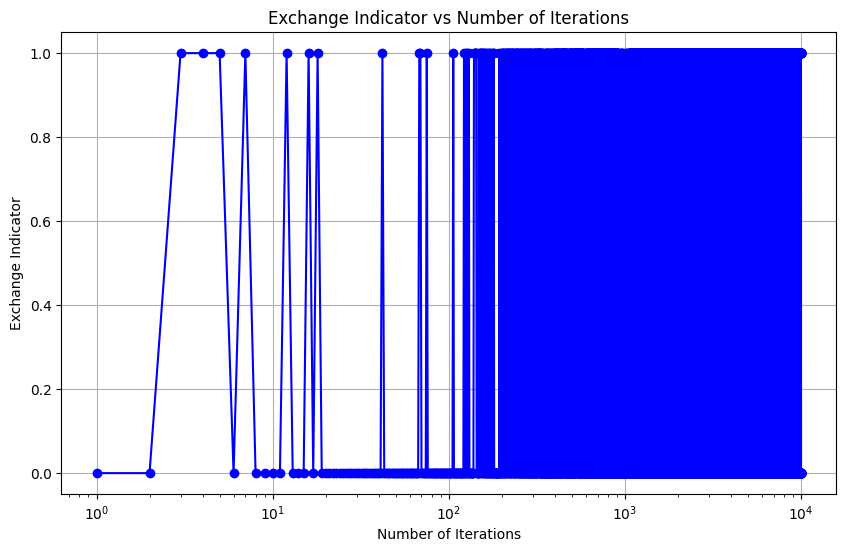

In [ ]:
import matplotlib.pyplot as plt

def plot_exchanges(exchanges, log_scale=False):
    """
    Plot the graph of exchanges against the number of iterations.

    Parameters:
    - optimal_values: List of optimal values.
    - log_scale: Boolean, whether to use a logarithmic scale for the x-axis.
    """
    iterations = range(1, len(exchanges) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, exchanges, marker='o', linestyle='-', color='b')
    plt.title('Exchange Indicator vs Number of Iterations')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Exchange Indicator')

    if log_scale:
        plt.xscale('log')

    plt.grid(True)
    plt.show()

# Example usage:
plot_exchanges(exchanges, log_scale=True)

**Function 11 (Visualize $U^n$)** <br>
Code to visualize how the points travelled by the algorithm change over the course of the iterations.

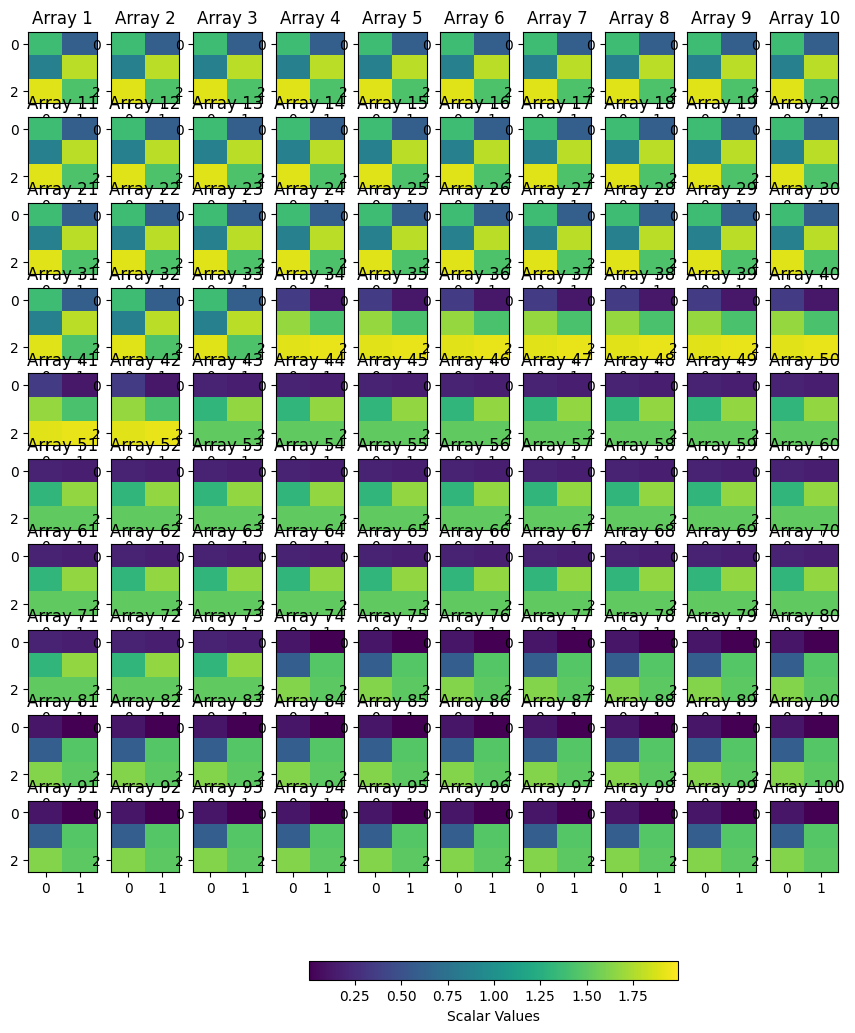

In [38]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Set up the layout of subplots
num_rows = 10
num_cols = 10

# Create a figure and axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each 2x3 array in u_points up to the number of available subplots
cmap = 'viridis'
vmin, vmax = np.min(u_points), np.max(u_points)

for i, array in enumerate(u_points[:len(axes)]):
    ax = axes[i]
    im = ax.imshow(array, cmap=cmap, interpolation='none', aspect='auto', vmin=vmin, vmax=vmax)
    #ax.set_title(f"Array {i+1}")

# Create a ScalarMappable
norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the ScalarMappable to work

# Create a colorbar
cbar = plt.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Scalar Values')

# Adjust layout using subplots_adjust
plt.subplots_adjust(bottom=0.2, right=0.8, top=0.9)

# Show the plot
plt.show()



**Function 12 (Automated SA)** <br>
There are a number of things inside the SA algorithm which are worth achieving. The first is the variation of the convergence with the temperature parameter $C$. Since this algorithm is a statistical one, we would like to see how well it is able to explore the domain. This exploration can be measured by looking
at each component of the U-step array and computing the quantities such as mean and variance for that particular component. Further, since this is a statistical algorithm, it has to be run multiple times for the same parameter set and the average values computed to get a correct idea of the algorithm.

We want an automation pipeline that varies parameters, stores them appropriately and then compiles in the form of some kind of a table. The parameters which we want to vary are the following: <br>
1. Cooling parameter $C$ <br>
2. Standard deviation of the Markov kernel $\sigma$ <br>


The metrics which we want to evaluate are following: <br>
1. Optimal value achieved by the algorithm $y^*$ <br>
2. Exploration estimate $V = Var(U)$ <br>
3. Number of exchanges $e$ <br>


The function can be called using the following: <br>
optimal_points, optimal_values, u_max, u_points, exchanges = simulated_annealing(tau, C, dimx, dimu, interval_I, sigma)

In [28]:
import numpy as np
import pandas as pd

def run_simulated_annealing(tau, C_values, sigma_values, num_trials, dimx, dimu, interval_I):
    results = []

    for C in C_values:
        for sigma in sigma_values:
            optimal_values_list = []
            exploration_variance_list = []
            exchanges_list = []

            for _ in range(num_trials):
                optimal_points, optimal_values, _, u_points, exchanges = simulated_annealing(tau, C, dimx, dimu, interval_I, sigma)

                optimal_values_list.append(max(optimal_values))
                exploration_variance_list.append(np.var(u_points, axis=0))
                exchanges_list.append(exchanges)

            # Calculate mean values across trials
            mean_optimal_value = np.mean(optimal_values_list)
            mean_exploration_variance = np.mean(exploration_variance_list, axis=0)
            mean_exchanges = np.mean(exchanges_list)

            # Append results for this parameter set
            results.append({
                'C': C,
                'sigma': sigma,
                'Mean_Optimal_Value': mean_optimal_value,
                'Mean_Exploration_Variance': mean_exploration_variance.tolist(),
                'Mean_Exchanges': mean_exchanges
            })

    # Create a DataFrame from the results
    df_results = pd.DataFrame(results)

    return df_results

# Example usage:
tau = 1000  # Number of iterations
C_values = [10e7, 10e8, 10e9, 10e10]  # Cooling parameter C values to be tested
sigma_values = [0.1, 0.5, 1.0]  # Standard deviation of the Markov kernel sigma values to be tested
num_trials = 5  # Number of trials for each parameter set
dimx = 3  # Dimension of X set
dimu = 2  # Dimension of U set
interval_I = (0, 2)  # Interval for constraint points

df_results = run_simulated_annealing(tau, C_values, sigma_values, num_trials, dimx, dimu, interval_I)




In [29]:
# Display the results
df_results

,C,sigma,Mean_Optimal_Value,Mean_Exploration_Variance,Mean_Exchanges
0,1.000000e+08,0.1,-4.512774e+07,"[[0.12577759538953256, 0.09664668758569958], [...",0.564565
1,1.000000e+08,0.5,-9.205266e+06,"[[0.14171864528724287, 0.16132915060181857], [...",0.966567
2,1.000000e+08,1.0,-6.670675e+06,"[[0.28237845317892674, 0.287162269221484], [0....",0.961361
3,1.000000e+09,0.1,-6.150991e+07,"[[0.017581978711824507, 0.006968710476065479],...",0.153353
4,1.000000e+09,0.5,-1.158356e+07,"[[0.12820569963470438, 0.2540750790491878], [0...",0.367568
5,1.000000e+09,1.0,-6.840624e+06,"[[0.46729363056198725, 0.2941992253870821], [0...",0.377778
6,1.000000e+10,0.1,-4.065935e+07,"[[0.0216163612211262, 0.01875750033760048], [0...",0.030230
7,1.000000e+10,0.5,-1.088942e+07,"[[0.09209554886029499, 0.2149201862832891], [0...",0.054855
8,1.000000e+10,1.0,-6.451022e+06,"[[0.31831902041746946, 0.3241850342618758], [0...",0.051852
9,1.000000e+11,0.1,-4.023484e+07,"[[0.003945728332606886, 0.04540243002132413], ...",0.010811
